##Импорт библиотек


In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

## Чтение данных


In [2]:
# Читаем данные
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

In [3]:
# Добавим колонку типов вин
red_wine['wine_type'] = 'red'
white_wine['wine_type'] = 'white'


In [4]:
# Объединим в один DataFrame
df = pd.concat([red_wine, white_wine], axis=0).reset_index(drop=True)

Data shape after removing outliers: (5024, 13)


In [5]:
# Базовая информация
print(df.info())

print(df.isnull().sum())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 5024 entries, 6 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5024 non-null   float64
 1   volatile acidity      5024 non-null   float64
 2   citric acid           5024 non-null   float64
 3   residual sugar        5024 non-null   float64
 4   chlorides             5024 non-null   float64
 5   free sulfur dioxide   5024 non-null   float64
 6   total sulfur dioxide  5024 non-null   float64
 7   density               5024 non-null   float64
 8   pH                    5024 non-null   float64
 9   sulphates             5024 non-null   float64
 10  alcohol               5024 non-null   float64
 11  quality               5024 non-null   int64  
 12  wine_type             5024 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 549.5+ KB
None
fixed acidity           0
volatile acidity        0
citric acid

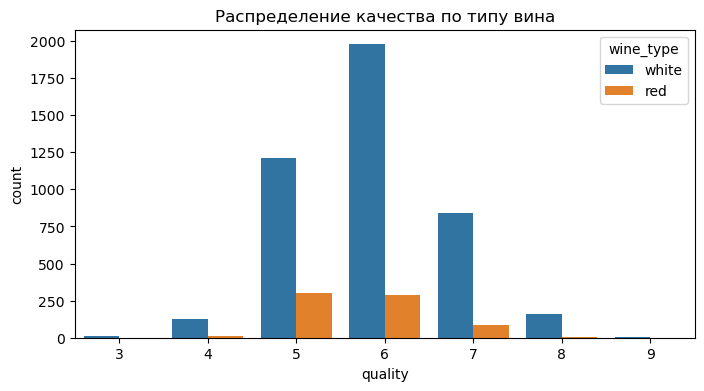

In [ ]:
# Посмотрим распределение
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='quality', hue='wine_type')
plt.title('Распределение качества по типу вина')
plt.show()

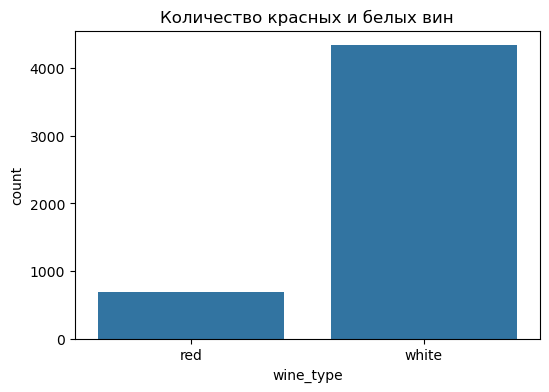

In [ ]:
# Распределение количества по типам вин
plt.figure(figsize=(6, 4))
sns.countplot(x='wine_type', data=df)
plt.title('Количество красных и белых вин')
plt.show()

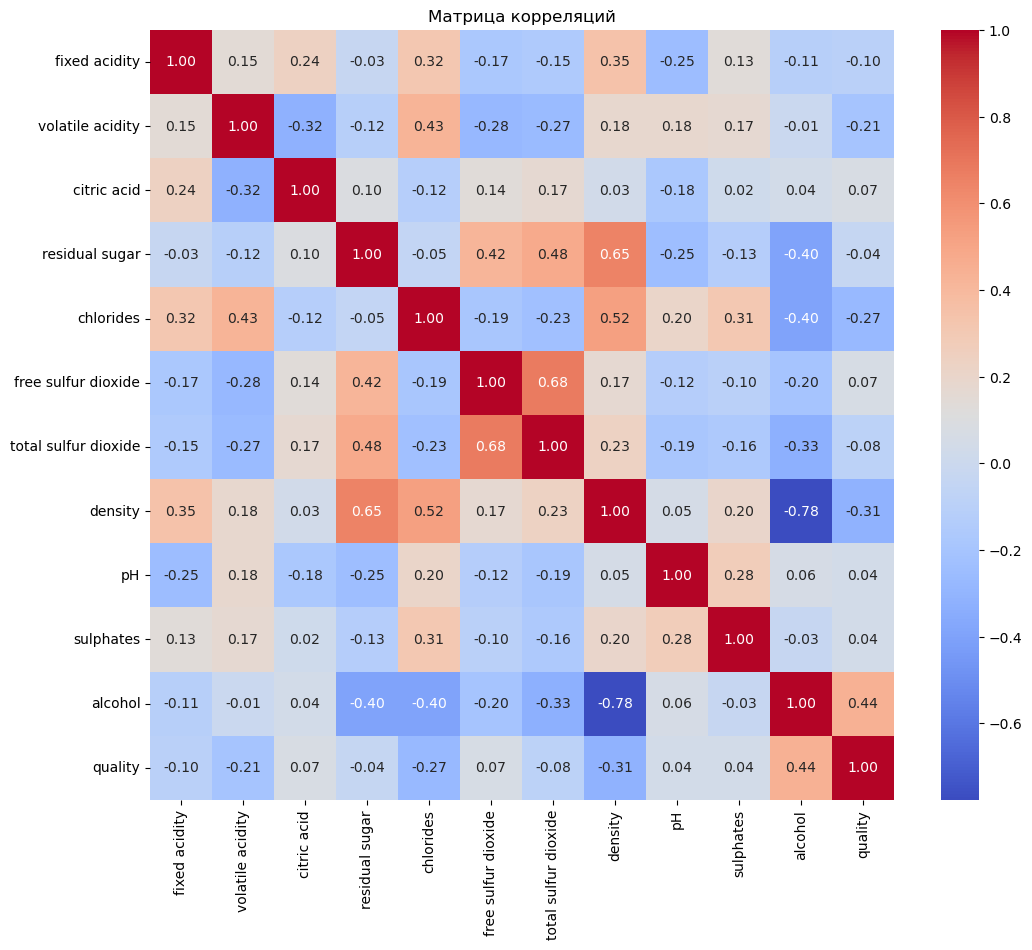

In [ ]:
# Корреляция признаков с quality
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

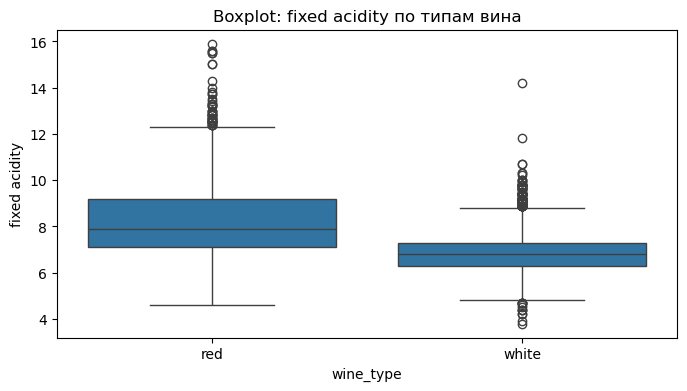

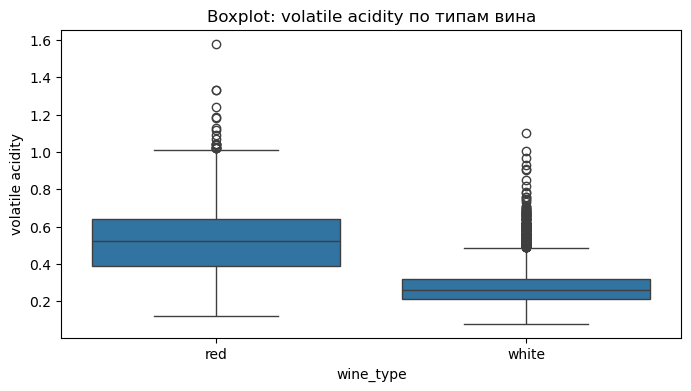

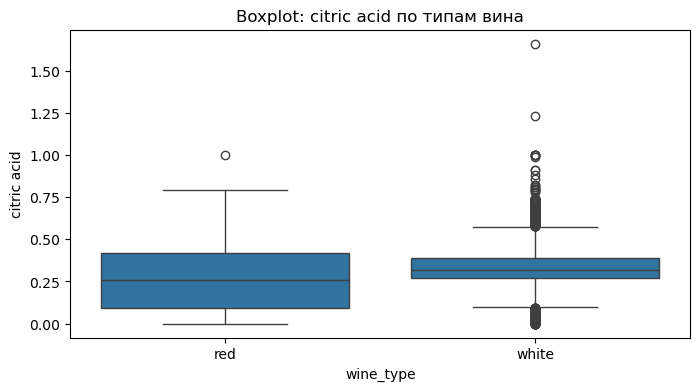

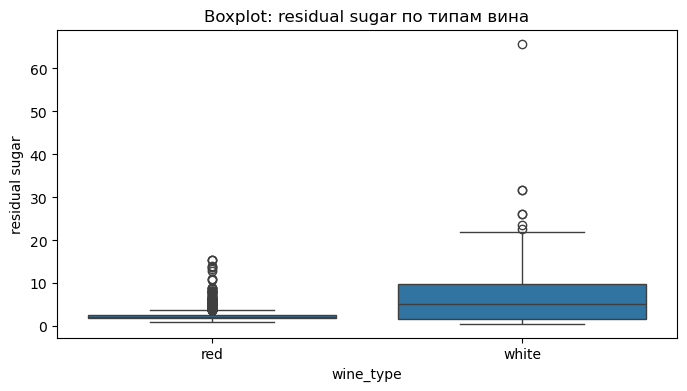

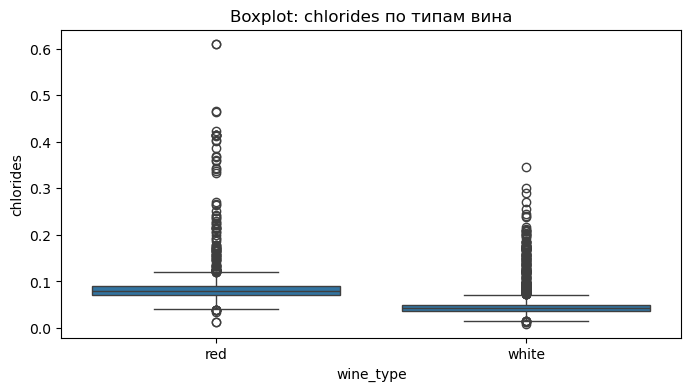

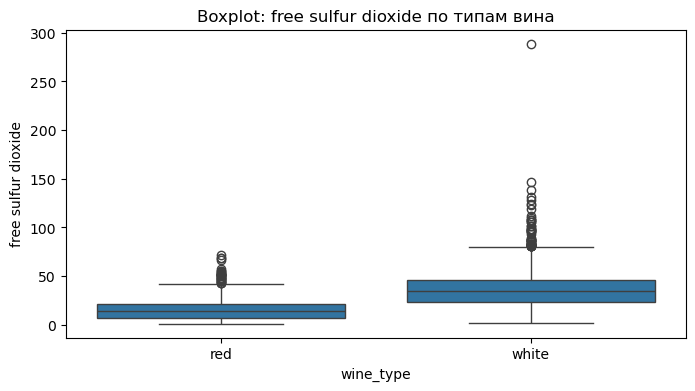

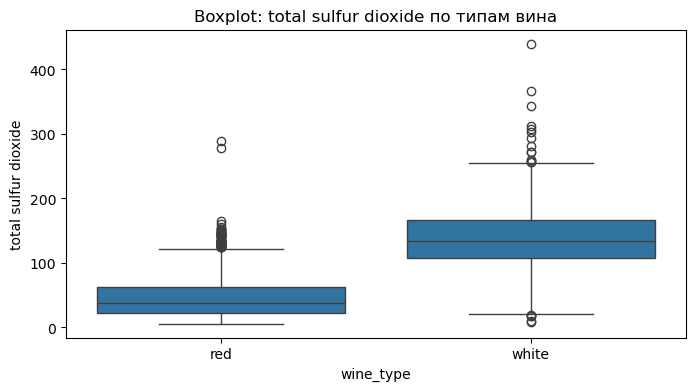

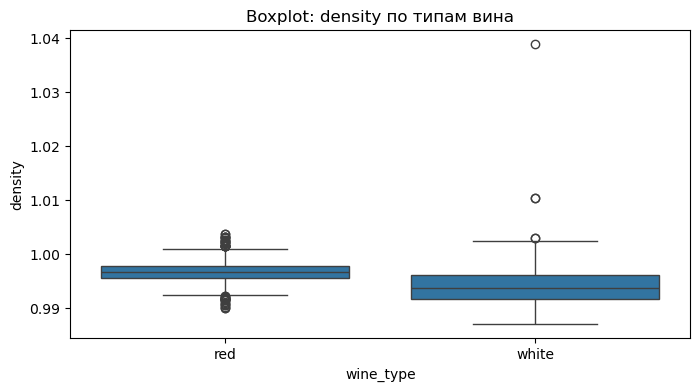

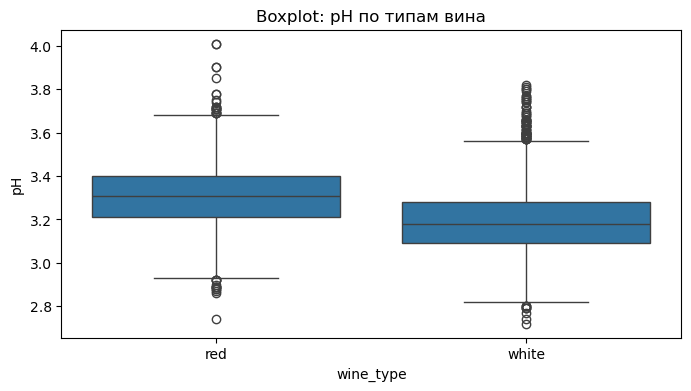

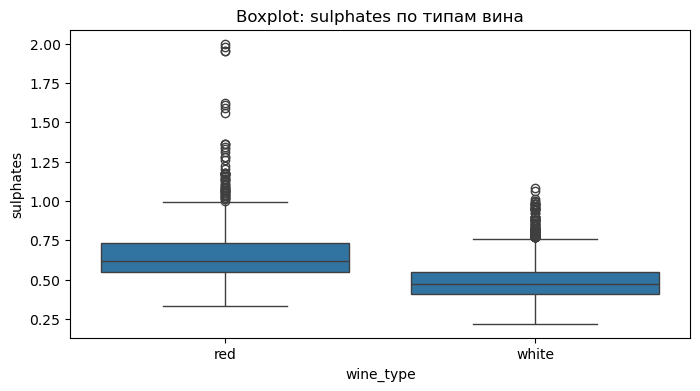

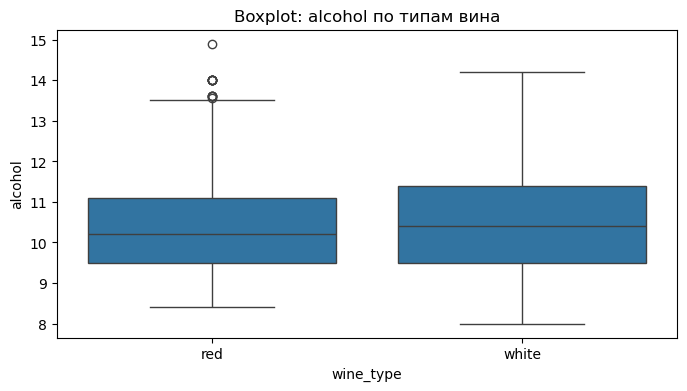

In [ ]:
# Boxplots для всех признаков
features = df.columns[:-2]

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='wine_type', y=feature)
    plt.title(f'Boxplot: {feature} по типам вина')
    plt.show()

## Обработка данных

In [ ]:
df_cleaned = df.copy()

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('quality')

outliers_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    n_outliers = outliers.shape[0]
    outliers_summary[col] = n_outliers

    print(f"{col}: {n_outliers} выбросов")

fixed acidity: 94 выбросов
volatile acidity: 274 выбросов
citric acid: 213 выбросов
residual sugar: 0 выбросов
chlorides: 270 выбросов
free sulfur dioxide: 0 выбросов
total sulfur dioxide: 4 выбросов
density: 0 выбросов
pH: 11 выбросов
sulphates: 31 выбросов
alcohol: 0 выбросов


In [ ]:
# Заменим выбросы на медиану
median_value = df[col].median()
df_cleaned.loc[df_cleaned[col] < lower_bound, col] = median_value
df_cleaned.loc[df_cleaned[col] > upper_bound, col] = median_value

In [ ]:
categorical_features = ['wine_type']
numerical_features = df_cleaned.select_dtypes(include=['float64', 'int64']).drop('quality', axis=1).columns.drop('wine_type', errors='ignore')


In [ ]:
# Создание StandardScaler и OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # drop='first' для избежания dummy trap
    ]
)

In [ ]:
# Применение трансформации
X_processed = preprocessor.fit_transform(df_cleaned)

ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_cols = list(numerical_features) + list(ohe_cols)

X_processed_df = pd.DataFrame(X_processed, columns=all_cols)
X_processed_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_white
0,1.061391,2.627147,-2.549293,-0.881375,1.320262,-1.084996,-1.320061,0.817659,0.604674,-0.386463,-0.978994,0.0
1,0.606080,1.755977,0.436637,0.119742,1.442567,-0.956639,-0.456301,1.320162,0.942374,2.533478,-0.058810,0.0
2,-0.304541,2.452913,-2.350231,-0.836881,3.032524,-1.084996,-1.199536,0.638193,0.469594,0.300582,-1.146300,0.0
3,0.606080,1.755977,0.436637,0.119742,1.442567,-0.956639,-0.456301,1.320162,0.942374,2.533478,-0.058810,0.0
4,1.744358,-0.160596,2.427257,-0.836881,2.726763,0.198571,-0.436214,0.997124,0.604674,2.104075,-0.058810,0.0


In [ ]:
# Создание фич и целевой переменной
X = X_processed_df.values
y = df['quality'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Преобразуем в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Создание модели

In [ ]:
class WineQualityNN(nn.Module):
    def __init__(self, input_size):
        super(WineQualityNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.output(x)
        x = self.sigmoid(x) * 6 + 3

In [ ]:
model = WineQualityNN(X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Обучение модели

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    batch_losses = []

    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    train_loss = sum(batch_losses) / len(batch_losses)
    train_losses.append(train_loss)

    # Валидация
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = loss_fn(y_val_pred, y_test_tensor).item()
        val_losses.append(val_loss)

    if epoch % 5 == 0 or epoch == n_epochs - 1:
        print(f'Epoch [{epoch+1}/{n_epochs}], '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Train Loss: 0.6372, Val Loss: 0.5029
Epoch [6/50], Train Loss: 0.4959, Val Loss: 0.4667
Epoch [11/50], Train Loss: 0.4657, Val Loss: 0.4390
Epoch [16/50], Train Loss: 0.4387, Val Loss: 0.4320
Epoch [21/50], Train Loss: 0.4221, Val Loss: 0.4460
Epoch [26/50], Train Loss: 0.4017, Val Loss: 0.4317
Epoch [31/50], Train Loss: 0.3975, Val Loss: 0.4291
Epoch [36/50], Train Loss: 0.3795, Val Loss: 0.4339
Epoch [41/50], Train Loss: 0.3732, Val Loss: 0.4392
Epoch [46/50], Train Loss: 0.3682, Val Loss: 0.4404
Epoch [50/50], Train Loss: 0.3491, Val Loss: 0.4243


## Вывод метрик оценки модели

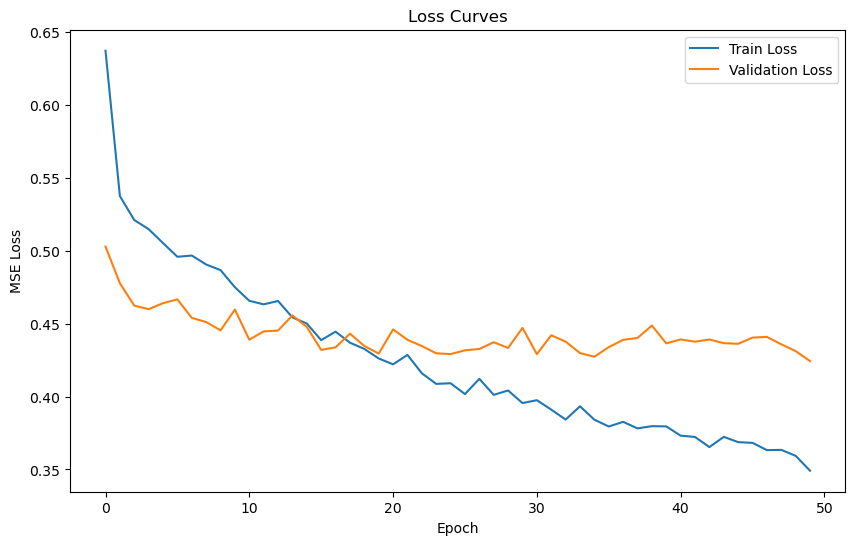

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test R²: {r2:.4f}')
print(f'Test MAE: {mae:.4f}')

Test R²: 0.4280
Test MAE: 0.4995


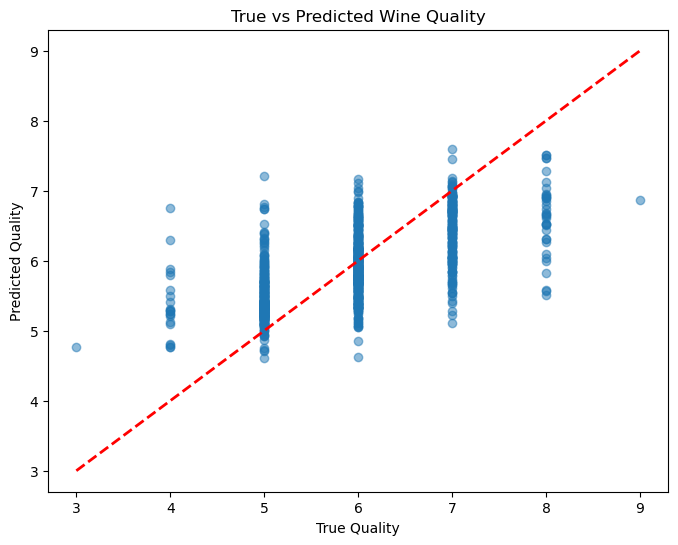

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('True Quality')
plt.ylabel('Predicted Quality')
plt.title('True vs Predicted Wine Quality')
plt.show()

In [ ]:
# Вообще, я тут могу сказать только про улучшению качества предсказаний модели, я бы добавил балансировку данных, так как предсказания крайних значений(3,8,9) очень слабы. Я пробовал усложнить модель, добавляя новые слои, l2 регурелизацию, но получил переобучение и решил использовать всё же этот варинт, так как времени не хватает 